<a href="https://colab.research.google.com/github/MohammadRaziei/Deep-Learning-Course/blob/master/HW03/Q4/CNN%20on%20CIFAR/CNN_on_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE-25620: Deep Learning

 # HW3.CNN on CIFAR (20 + 10 points)

In this problem, we will train a CNN on CIFAR-10 database. Next, we will go through the network and visualize its layers to see what is happening there. Then, we use the trained model in a Transfer Learning approach to classifying the CIFAR-100 database.

Let's start with loading data. First load the data by runing the code below:

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [1]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
!curl -LO  'https://github.com/MohammadRaziei/Deep-Learning-Course/raw/master/HW03/Q4/CNN%20on%20CIFAR/load_data.py'
!curl -LO  'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz' 
!mkdir -p data
!tar -xf cifar-10-python.tar.gz -C data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   180  100   180    0     0   1463      0 --:--:-- --:--:-- --:--:--  1463
100  2785  100  2785    0     0  12659      0 --:--:-- --:--:-- --:--:-- 12659
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  91.8M      0  0:00:01  0:00:01 --:--:-- 91.8M


In [2]:
from load_data import load_cifar10 #this function provided in the attached file loads the data of CIFAR10 database

def load_cifar10_data():
    dataset_dir = 'data/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_cifar10(dataset_dir)
    X_train, X_val = X_train[:45000], X_train[45000:]
    y_train, y_val = y_train[:45000], y_train[45000:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 1)
X_val shape: (5000, 32, 32, 3)
y_val shape: (5000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


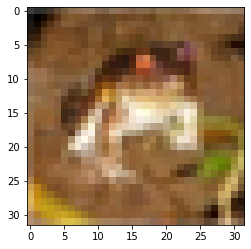

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10_data()
X_train, X_val, X_test = X_train/255., X_val/255., X_test/255.

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

import matplotlib.pyplot as plt
plt.imshow(X_train[0])#represnting a sample data from CIFAR-10
plt.show()

By successfully runing the above code, you have loaded the data and also you can see a sample data from CIFAR-10.

The below code will convert the labels to one-hot codes which will be later used for the classification.

In [4]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder # this function is used to prepare one-hot encoded labels
encoder = OneHotEncoder(sparse=False)

encoder.fit(y_train)#this line will fit 'encoder' to encode the labels

y_train_onehot = encoder.transform(y_train)# encoding train labels (one-hot coding)
y_val_onehot   = encoder.transform(y_val)  # encoding train labels (one-hot coding)
y_test_onehot  = encoder.transform(y_test) # encoding test  labels (one-hot coding)

The function below is for converting data to several batches which we will use in training.

In [5]:
def make_batches(x, y, batch_size):
    n = len(y)
    steps = n // batch_size
    if n % batch_size != 0:
        steps += 1
    x_batches = np.array_split(x, steps)
    y_batches = np.array_split(y, steps)
    return x_batches, y_batches

## Part1: Trainig a CNN (15 pts.)

In this part, we are going to train a Convolutional Neural Network (CNN) with the below structure:

1. 16 * conv(5,5), activation function =ReLU
2. 16 * conv(5,5), activation function =ReLU
3. Max-pooling(3,3), stride=(2,2)
4. 32 * conv(5,5), activation function =ReLU
5. 32 * conv(5,5), activation function =ReLU
6. Max-pooling(3,3), stride=(2,2)
7. 64 * conv(5,5), activation function =ReLU
8. FC(128), activation function =ReLU
9. FC(128), activation function =ReLU
10. FC(10), activation function =softmax

Let's go to implement the model in the below box. Note that using **tf.layers** is **NOT ALLOWED** in this homework.

In [9]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

x = tf.placeholder(tf.float32, [None, 32, 32, 3]) # placeholder for input data
y = tf.placeholder(tf.float32, [None, 10])# placeholder for labels (one-hot encoded)

init = lambda shape: tf.truncated_normal(shape=shape, mean = 0.0, stddev = 0.01)

# Define needed variables here:
W_conv1 = tf.Variable(init(shape=[5, 5, 3, 16]),name="W_conv1")
B_conv1 = tf.Variable(init(shape=[16]),name="B_conv1")
W_conv2 = tf.Variable(init(shape=[5, 5, 16, 16]),name="W_conv2")
B_conv2 = tf.Variable(init(shape=[16]),name="B_conv2")
W_conv3 = tf.Variable(init(shape=[5, 5, 16, 32]),name="W_conv3")
B_conv3 = tf.Variable(init(shape=[32]),name="B_conv3")
W_conv4 = tf.Variable(init(shape=[5, 5, 32, 32]),name="W_conv4")
B_conv4 = tf.Variable(init(shape=[32]),name="B_conv4")
W_conv5 = tf.Variable(init(shape=[5, 5, 32, 64]),name="W_conv5")
B_conv5 = tf.Variable(init(shape=[64]),name="B_conv5")

# W_FC1 = tf.Variable(init(shape=[tf.math.reduce_prod(conv5.shape[1:]), 128]),name="W_FC1")
W_FC1 = tf.Variable(init(shape=[4096, 128]),name="W_FC1")
B_FC1 = tf.Variable(init(shape=[128]),name="B_FC1")
W_FC2 = tf.Variable(init(shape=[128, 128]),name="W_FC2")
B_FC2 = tf.Variable(init(shape=[128]),name="B_FC2")
W_logits = tf.Variable(init(shape=[128, 10]),name="W_logits")
B_logits = tf.Variable(init(shape=[10]),name="B_logits")

O_BN1 = tf.Variable(init(shape=[32]))
S_BN1 = tf.Variable(init(shape=[32]))

# Define layers here:
conv1 = tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + B_conv1
conv1_relu = tf.nn.relu(conv1)
drop1 = tf.nn.dropout(conv1_relu, rate=0.5)
conv2 = tf.nn.conv2d(drop1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + B_conv2
conv2_relu = tf.nn.relu(conv2)
pooling1 = tf.nn.max_pool(conv2_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
conv3 = tf.nn.conv2d(pooling1, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + B_conv3
conv3_relu = tf.nn.relu(conv3)
drop2 = tf.nn.dropout(conv3_relu, rate=0.5)
bn1 = tf.nn.batch_normalization(drop2,mean=tf.reduce_mean(drop2),variance=tf.math.reduce_variance(drop2),offset=O_BN1, scale=S_BN1, variance_epsilon=0.01)
conv4 = tf.nn.conv2d(bn1, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + B_conv4
conv4_relu = tf.nn.relu(conv4)
pooling2 = tf.nn.max_pool(conv4_relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
conv5 = tf.nn.conv2d(pooling2, W_conv5, strides=[1, 1, 1, 1], padding='SAME') + B_conv5
conv5_relu = tf.nn.relu(conv5)   

flat_conv5 = tf.reshape(conv5_relu, [-1, conv5.shape[1]*conv5.shape[2]*conv5.shape[3]])

FC1 = tf.matmul(flat_conv5, W_FC1) + B_FC1
FC1_relu = tf.nn.relu(FC1)
FC2 = tf.matmul(FC1_relu, W_FC2) + B_FC2
FC2_relu = tf.nn.relu(FC2)
logits = tf.matmul(FC2_relu, W_logits) + B_logits
y_hat = tf.nn.softmax(logits)

Now you need to define an optimizer. You are free to use any optimizer. You can change optimizer or learning rate if you want :)

In [10]:
# Cross entropy loss:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
# Note: logits in the above line is the last layer values (a 10-neuron layer) before the softmax activation function. 
#       In other words, you may have written y_hat = tf.nn.softmax(logits) in the above box in which y_hat is the output
#       of the network.

# Adam optimizer:
lr = 1e-4 # learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
trainer = optimizer.minimize(cross_entropy)

# TODO: Implement Accuracy:
correct_preds = tf.argmax(y, axis=1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_hat, axis=1), correct_preds),tf.float64))
# Note: The defined accuray does not play any role in the optimization process. However, it is a mtric which we can 
#       use as a log for mintoring training process with more metrics rather than a single loss function.


You can go for the rest of the job, handle the Session and go for training. 
You can use tensorboard or the code provided in the next box to plot for loss and accuracy of training and validation data.
You are expected to achieve at least 60% accuracy on the test data after the training process. Good Luck! ;)

In [14]:
########## Training ##########
batch_size = 64 # You are free to change it
x_train_batches, y_train_batches = make_batches(X_train, y_train_onehot, batch_size)
epochs = 100  # You are free to change it
N_Batches = len(x_train_batches)

train_acc  = np.zeros(epochs)
train_loss = np.zeros(epochs)
val_acc  = np.zeros(epochs)
val_loss = np.zeros(epochs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        print()
        print("*" * 10, "Epoch {}".format(epoch+1), "*" * 10)

        batch_acc = np.zeros(N_Batches)
        batch_loss = np.zeros(N_Batches)
        for n in range(N_Batches):
            _, batch_acc[n], batch_loss[n] = sess.run([trainer, accuracy, cross_entropy],
                                                      {x: x_train_batches[n], y: y_train_batches[n]})
            #print("Batch %3d/%d: Acc:%0.4f , Loss:%0.4f"%(n, N_Batches, batch_acc[n], batch_loss[n]))

        train_acc[epoch] = np.mean(batch_acc)
        train_loss[epoch] = np.mean(batch_loss)
        print("Train:\t\tAccuracy= %0.4f \tLoss= %0.4f"%(train_acc[epoch], train_loss[epoch]))

        ########## Validation ##########
        val_acc[epoch], val_loss[epoch] = sess.run([accuracy, cross_entropy],
                                                   {x: X_val, y: y_val_onehot})
        print("Validation:\tAccuracy= %0.4f \tLoss= %0.4f"%(val_acc[epoch], val_loss[epoch]))
        
    ############################################################
    #            TODO: Implement Test Phase                    #
    ############################################################
    test_acc, test_loss = sess.run([accuracy, cross_entropy],{x: X_test, y: y_test_onehot})
    print("Test:\tAccuracy= %0.4f \tLoss= %0.4f"%(test_acc, test_loss))
    ############################################################
    


********** Epoch 1 **********
Train:		Accuracy= 0.1005 	Loss= 2.3026
Validation:	Accuracy= 0.0958 	Loss= 2.3027

********** Epoch 2 **********
Train:		Accuracy= 0.1005 	Loss= 2.3026
Validation:	Accuracy= 0.0958 	Loss= 2.3027

********** Epoch 3 **********
Train:		Accuracy= 0.2178 	Loss= 2.0462
Validation:	Accuracy= 0.2616 	Loss= 1.9195

********** Epoch 4 **********
Train:		Accuracy= 0.2834 	Loss= 1.8756
Validation:	Accuracy= 0.3034 	Loss= 1.8352

********** Epoch 5 **********
Train:		Accuracy= 0.3081 	Loss= 1.8065
Validation:	Accuracy= 0.3156 	Loss= 1.7694

********** Epoch 6 **********
Train:		Accuracy= 0.3307 	Loss= 1.7520
Validation:	Accuracy= 0.3368 	Loss= 1.7252

********** Epoch 7 **********
Train:		Accuracy= 0.3427 	Loss= 1.7162
Validation:	Accuracy= 0.3438 	Loss= 1.7011

********** Epoch 8 **********
Train:		Accuracy= 0.3562 	Loss= 1.6893
Validation:	Accuracy= 0.3558 	Loss= 1.6820

********** Epoch 9 **********
Train:		Accuracy= 0.3708 	Loss= 1.6615
Validation:	Accuracy= 0.36

### Training Diagram

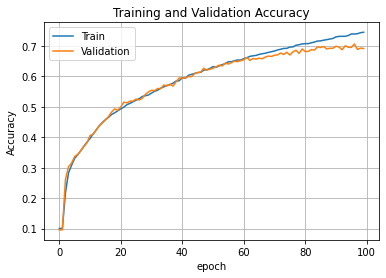

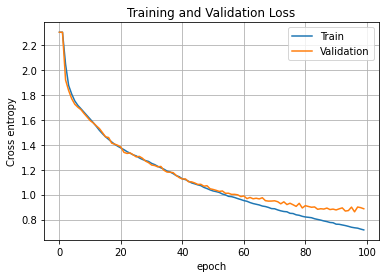

In [15]:
########## Plot metrics #########################
fig = plt.figure()
plt.plot(range(epochs), train_acc, label='Train')
plt.plot(range(epochs), val_acc, label='Validation')
plt.title("Training and Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc=0)
plt.show()

fig = plt.figure()
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), val_loss, label='Validation')
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("Cross entropy")
plt.grid(True)
plt.legend(loc=0)
plt.show()

## Part2: Visualizing the Network (5 pts.)

Now, we want to check the weights to see how the network realy works and what it does. Consider the wieghts of the first convolutional layer, find its weights values and print the values of 2 arbitrary filters:

In [16]:
##########################################################################
# TODO                                                                   #
# Note: To retrieve the values of the weight-variables from TensorFlow,  #
#       feed-dict is not necessary because                               #
#       nothing is calculated.                                           #
#       e.g., w = sess.run(weights)                                      #
##########################################################################

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    w1 = sess.run(W_conv1)
    print(w1)
    w2 = sess.run(W_conv5)
    print(w2)
##########################################################################

[[[[-1.04067065e-02  1.25288439e-03  2.08075950e-03 ... -6.31039822e-03
     7.34447408e-03 -6.98217843e-03]
   [-1.76182701e-04  3.38691846e-03  3.14599107e-04 ...  4.02315799e-03
     1.15948487e-02  1.11809922e-02]
   [ 7.32803345e-03 -4.09529544e-03  2.17887602e-04 ...  4.52842750e-03
     2.59729940e-03  4.27989755e-03]]

  [[ 9.99654760e-04  1.30748162e-02 -1.42263519e-02 ... -1.89452227e-02
    -2.43292958e-03  5.79107879e-03]
   [-3.93735198e-03 -8.63881491e-04  5.68772957e-04 ... -9.23504820e-04
    -1.18311644e-02  1.15020107e-03]
   [-6.39614242e-04  5.84293110e-03  4.69530094e-03 ...  1.79022532e-02
     1.90226510e-02 -5.68374759e-04]]

  [[ 3.66364443e-03  1.22114886e-02  4.77758795e-03 ... -8.69363919e-03
     1.35442726e-02  1.03113828e-02]
   [ 3.73552321e-03 -2.09587533e-03  8.14392697e-05 ...  6.79840241e-03
    -8.09038710e-03  7.05219479e-03]
   [-1.17678763e-02 -2.31644604e-03  1.73195987e-03 ... -1.23595316e-02
    -3.29367747e-03  1.52285974e-02]]

  [[ 6.528899

### Question: Try to interpret what they are doing?

### Answer: 

> These weights can demostrate whether feature is important or not.

Now let's visualize the filters of the first conv layer. There are lots of ways to code for visualization. You are free to choose any way you want. However below is function which is provided for you to plot the weights.

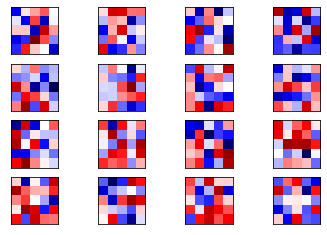

In [17]:
import math
def plot_conv_weights(w, input_channel=0):
    # The argument w is a 4-dim array.(e.g. weights_conv1 with the shape of [5,5,3,64])
    # The argument input_channel shows the specified channel of all filters.
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

    
##########################################################################
# TODO: call the function above or use your own way here                 #
##########################################################################

plot_conv_weights(w1, 0)

##########################################################################


### Question: Try to interpret what they are doing?

### Answer: 

> It's a visualization for filters to make more sense for its job in neural net and it is show high and low pass filters in that.

## Part3: Transfer Learning (+10 pts. - optional)

In all the machine learning problems we need data to train our models. However, the volume of the data might not be sufficient for the considered model. In such cases, we may use a model which is trained on a similar dataset probably for a different objective. Then we transfer to the main problem and fine- tune or replace some parts of the network. 

In this exercise, we are going to implement the transfer learning concept on CNN. For this purpose, we use the network that you have trained on Part 1 of this homework (above) to classify three new classes (i.e. bee, elephant, and fox) on CIFAR-100 dataset. Let's first load the data:

In [61]:
!curl -LO  'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz' 
!mkdir -p data
!tar -xf cifar-100-python.tar.gz -C data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  161M  100  161M    0     0  95.0M      0  0:00:01  0:00:01 --:--:-- 95.0M


In [23]:
from load_data import load_cifar100 #this function provided in the attached file loads the data of CIFAR100 database

def load_cifar100_data():
    dataset_dir = 'data/cifar-100-python'
    
    X_train, y_train, X_test, y_test = load_cifar100(dataset_dir)
    
    return X_train, y_train, X_test, y_test

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


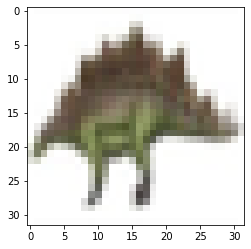

In [24]:
X_train, y_train, X_test, y_test = load_cifar100_data()
X_train, X_test = X_train/255., X_test/255.

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

import matplotlib.pyplot as plt
plt.imshow(X_train[1])#represnting a sample data from CIFAR-100
plt.show()

By successfully runing the above code, you have loaded the data and also you can see a sample data from CIFAR-100. The below code will seprate the specified classes (i.e. bee(6), elephant(31), and fox(34)) for the new classification problem.

In [25]:
selected_images_train = np.zeros([1,32,32,3])
selected_labels_train = np.zeros([1,1])
for i in range(50000):
    label = y_train[i]
    if label==6 or label==31 or label==34:
        selected_images_train = np.append(selected_images_train,np.reshape(X_train[i,:,:,:],[1,32,32,3]),axis=0)
        selected_labels_train = np.append(selected_labels_train,np.reshape(label,[1,1]),axis=0)
selected_images_train = selected_images_train[1:]# to remove the first defined np..zeros data
selected_labels_train = selected_labels_train[1:]# to remove the first defined np..zeros data


selected_images_test = np.zeros([1,32,32,3])
selected_labels_test = np.zeros([1,1])
for i in range(10000):
    label = y_test[i]
    if label==6 or label==31 or label==34:
        selected_images_test = np.append(selected_images_test,np.reshape(X_test[i,:,:,:],[1,32,32,3]),axis=0)
        selected_labels_test = np.append(selected_labels_test,np.reshape(label,[1,1]),axis=0)
selected_images_test = selected_images_test[1:]# to remove the first defined np..zeros data
selected_labels_test = selected_labels_test[1:]# to remove the first defined np..zeros data

In [26]:
images_train = selected_images_train[:int(selected_images_train.shape[0]*0.8),:,:,:]
labels_train = selected_labels_train[:int(selected_images_train.shape[0]*0.8),:]

images_validation = selected_images_train[int(selected_images_train.shape[0]*0.8):,:,:,:]
labels_validation = selected_labels_train[int(selected_images_train.shape[0]*0.8):,:]

images_test = selected_images_test
labels_test = selected_labels_test


print('images_train shape:', images_train.shape)
print('labels_train shape:', labels_train.shape)

print('images_validation shape:', images_validation.shape)
print('labels_validation shape:', labels_validation.shape)

print('images_test shape:', images_test.shape)
print('labels_test shape:', labels_test.shape)

images_train shape: (1200, 32, 32, 3)
labels_train shape: (1200, 1)
images_validation shape: (300, 32, 32, 3)
labels_validation shape: (300, 1)
images_test shape: (300, 32, 32, 3)
labels_test shape: (300, 1)


In [27]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder # this function is used to prepare one-hot encoded labels
encoder = OneHotEncoder(sparse=False)

encoder.fit(selected_labels_train)#this line will fit 'encoder' to encode the labels

labels_train_onehot = encoder.transform(labels_train)# encoding train labels (one-hot coding)
labels_val_onehot   = encoder.transform(labels_validation)  # encoding train labels (one-hot coding)
labels_test_onehot  = encoder.transform(labels_test) # encoding test  labels (one-hot coding)

To implement the transfer learning, we need to use the previous model and transfer it to the new problem. For this end, you need to freeze the convolution layers and also the first fully connected layer which means that they should not be updated in the new training process. For the last two fully connected layers, we want to fine-tune the values. However, you should replace the last layer (output layer) with a 3-neuron layer to represent the score for each class.

There are several methods that you can implement the discussed process with TensorFlow. You are free to do any way you want.
The below code redefine the network and use the weights of the network trained on CIFAR-10. Then, the frozen weights can be defined as either constant or non-trainable variables. Besides, the fine-tuning weights are also defined as variables with their previous weights in the definition. Anyway, since there are other ways to implement this job, you can do it with your own method.

In [48]:
############################################################
#            TODO: Implement Accuracy Part                 #
############################################################

# get the weights form previous network:
# e.g., w_conv1_CIFAR10 = sess.run(W_conv1)

with tf.Session() as sess:
	sess.run(tf.global_variables_initializer())

	W_conv1_CIFAR10  = sess.run(W_conv1 )
	B_conv1_CIFAR10  = sess.run(B_conv1 )
	W_conv2_CIFAR10  = sess.run(W_conv2 )
	B_conv2_CIFAR10  = sess.run(B_conv2 )
	W_conv3_CIFAR10  = sess.run(W_conv3 )
	B_conv3_CIFAR10  = sess.run(B_conv3 )
	W_conv4_CIFAR10  = sess.run(W_conv4 )
	B_conv4_CIFAR10  = sess.run(B_conv4 )
	W_conv5_CIFAR10  = sess.run(W_conv5 )
	B_conv5_CIFAR10  = sess.run(B_conv5 )

	W_FC1_CIFAR10    = sess.run(W_FC1   )
	B_FC1_CIFAR10    = sess.run(B_FC1   )
	W_FC2_CIFAR10    = sess.run(W_FC2   )
	B_FC2_CIFAR10    = sess.run(B_FC2   )
	W_logits_CIFAR10 = sess.run(W_logits)
	B_logits_CIFAR10 = sess.run(B_logits)

	O_BN1_CIFAR10    = sess.run(O_BN1   )
	S_BN1_CIFAR10    = sess.run(S_BN1   )
 

# tf.reset_default_graph()

x_new = tf.placeholder(tf.float32, [None, 32, 32, 3]) # placeholder for input data
y_new = tf.placeholder(tf.float32, [None, 3])# placeholder for labels (one-hot encoded)

# Re-define the convolutional layers
conv1_CIFAR100 = tf.nn.conv2d(x_new, W_conv1_CIFAR10, strides=[1, 1, 1, 1], padding='SAME') + B_conv1_CIFAR10
conv1_relu_CIFAR100 = tf.nn.relu(conv1_CIFAR100)
drop1_CIFAR100 = tf.nn.dropout(conv1_relu_CIFAR100, rate=0.5)
conv2_CIFAR100 = tf.nn.conv2d(drop1_CIFAR100, W_conv2_CIFAR10, strides=[1, 1, 1, 1], padding='SAME') + B_conv2_CIFAR10
conv2_relu_CIFAR100 = tf.nn.relu(conv2_CIFAR100)
pooling1_CIFAR100 = tf.nn.max_pool(conv2_relu_CIFAR100, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
conv3_CIFAR100 = tf.nn.conv2d(pooling1_CIFAR100, W_conv3_CIFAR10, strides=[1, 1, 1, 1], padding='SAME') + B_conv3_CIFAR10
conv3_relu_CIFAR100 = tf.nn.relu(conv3_CIFAR100)
drop2_CIFAR100 = tf.nn.dropout(conv3_relu_CIFAR100, rate=0.5)
bn1_CIFAR100 = drop2_CIFAR100# bn1_CIFAR100 = tf.nn.batch_normalization(drop2_CIFAR100,mean=tf.reduce_mean(drop2_CIFAR100),variance=tf.math.reduce_variance(drop2_CIFAR100),offset=O_BN1_CIFAR10, scale=S_BN1_CIFAR10, variance_epsilon=0.01)
conv4_CIFAR100 = tf.nn.conv2d(bn1_CIFAR100, W_conv4_CIFAR10, strides=[1, 1, 1, 1], padding='SAME') + B_conv4_CIFAR10
conv4_relu_CIFAR100 = tf.nn.relu(conv4_CIFAR100)
pooling2_CIFAR100 = tf.nn.max_pool(conv4_relu_CIFAR100, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
conv5_CIFAR100 = tf.nn.conv2d(pooling2_CIFAR100, W_conv5_CIFAR10, strides=[1, 1, 1, 1], padding='SAME') + B_conv5_CIFAR10
conv5_relu_CIFAR100 = tf.nn.relu(conv5_CIFAR100)   

flat_conv5_CIFAR100 = tf.reshape(conv5_relu_CIFAR100, [-1, tf.math.reduce_prod(conv5_relu_CIFAR100.shape[1:])])

FC1_CIFAR100 = tf.matmul(flat_conv5_CIFAR100, W_FC1_CIFAR10) + B_FC1_CIFAR10
FC1_relu_CIFAR100 = tf.nn.relu(FC1_CIFAR100)





#############################################################
# Define weights for the second FC layer (fc1 is already defined in the previous model)
init = lambda shape: tf.truncated_normal(shape=shape, mean = 0.0, stddev = 0.5)

W_fc2_new = tf.Variable(init(shape=[128, 128]),name="W_fc2_new")
B_fc2_new = tf.Variable(init(shape=[128]),name="B_fc2_new")
W_fc3_new = tf.Variable(init(shape=[128, 3]),name="W_fc3_new")
B_fc3_new = tf.Variable(init(shape=[3]),name="B_fc3_new")

# Define based on the first fully connected layer.
fc2_new = tf.nn.relu(tf.matmul(FC1_relu_CIFAR100, W_fc2_new) + B_fc2_new)

# Define based on the second fully connected layer (fc2_new).
logit = tf.matmul(fc2_new, W_fc3_new) + B_fc3_new
y_hat = tf.nn.softmax(logit)

########## Cross entropy loss ##########
new_cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=y_new))
regularizers = tf.nn.l2_loss(W_fc3_new) + tf.nn.l2_loss(W_fc2_new)
beta=0.00001
new_cross_entropy += regularizers * beta
############################################################
#            TODO: Implement the optimizer so that only    #
#                  variales defined above are updated.     #
############################################################
lr = 5e-3
new_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
new_trainer = new_optimizer.minimize(new_cross_entropy, var_list=[W_fc2_new, B_fc2_new, B_fc3_new, B_fc3_new])
############################################################

############################################################
#            TODO: Implement Accuracy                      #
############################################################
correct_preds = tf.argmax(y_new, axis=1)
new_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_hat, axis=1), correct_preds),tf.float64)) 
############################################################


Now, go for the rest of the job and start training:

In [51]:
########## Training ##########
batch_size = 64 # You are free to change it
x_train_batches, y_train_batches = make_batches(images_train, labels_train_onehot, batch_size)
epochs = 100# You are free to change it
N_Batches = len(x_train_batches)

train_acc  = np.zeros(epochs)
train_loss = np.zeros(epochs)
val_acc  = np.zeros(epochs)
val_loss = np.zeros(epochs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        print()
        print("*" * 10, "Epoch %3i"%epoch, "*" * 10)

        batch_acc = np.zeros(N_Batches)
        batch_loss = np.zeros(N_Batches)
        for n in range(N_Batches):
            _, batch_acc[n], batch_loss[n] = sess.run([new_trainer, new_accuracy, new_cross_entropy],
                                                      {x_new: x_train_batches[n], y_new: y_train_batches[n]})
            #print("Batch %3d/%d: Acc:%0.4f , Loss:%0.4f"%(n, N_Batches, batch_acc[n], batch_loss[n]))

        train_acc[epoch] = np.mean(batch_acc)
        train_loss[epoch] = np.mean(batch_loss)
        print("Train:\t\tAccuracy= %0.4f \tLoss= %0.4f"%(train_acc[epoch], train_loss[epoch]))

        ########## Validation ##########
        val_acc[epoch], val_loss[epoch] = sess.run([new_accuracy, new_cross_entropy],
                                                   {x_new: images_validation, y_new: labels_val_onehot})
        print("Validation:\tAccuracy= %0.4f \tLoss= %0.4f"%(val_acc[epoch], val_loss[epoch]))
        
############################################################
#            TODO: Implement Test Phase                    #
############################################################
    test_acc, test_loss = sess.run([new_accuracy, new_cross_entropy],{x_new: images_test, y_new: labels_test_onehot})
    print("Test:\tAccuracy= %0.4f \tLoss= %0.4f"%(test_acc, test_loss))
############################################################

********** Epoch   0 **********
Train:		Accuracy= 0.3892 	Loss= 1.5071
Validation:	Accuracy= 0.4400 	Loss= 1.1021

********** Epoch   1 **********
Train:		Accuracy= 0.4633 	Loss= 1.0837
Validation:	Accuracy= 0.4533 	Loss= 1.0397

********** Epoch   2 **********
Train:		Accuracy= 0.5267 	Loss= 1.0278
Validation:	Accuracy= 0.5433 	Loss= 0.9799

********** Epoch   3 **********
Train:		Accuracy= 0.5608 	Loss= 0.9889
Validation:	Accuracy= 0.5667 	Loss= 0.9421

********** Epoch   4 **********
Train:		Accuracy= 0.5767 	Loss= 0.9582
Validation:	Accuracy= 0.5800 	Loss= 0.9137

********** Epoch   5 **********
Train:		Accuracy= 0.5917 	Loss= 0.9321
Validation:	Accuracy= 0.5967 	Loss= 0.8910

********** Epoch   6 **********
Train:		Accuracy= 0.6033 	Loss= 0.9105
Validation:	Accuracy= 0.6067 	Loss= 0.8730

********** Epoch   7 **********
Train:		Accuracy= 0.6133 	Loss= 0.8928
Validation:	Accuracy= 0.6267 	Loss= 0.8569

********** Epoch   8 **********
Train:		Accuracy= 0.6300 	Loss= 0.8777
Validatio

You can use tensorboard or the code provided in the next box to plot for loss and accuracy of training and validation data. You are expected to achieve at least 80% accuracy on the test data after training. Good Luck! ;)

### Training Diagram

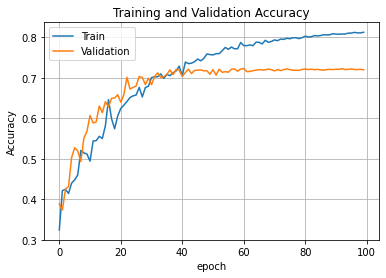

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


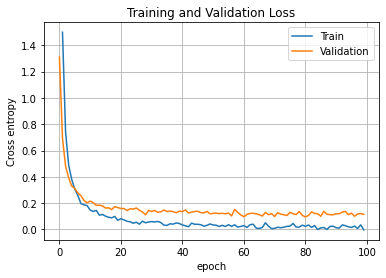

In [94]:
########## Plot metrics #########################
s = np.arange(100)
fig = plt.figure()
plt.plot(range(epochs), train_acc, label='Train')
plt.plot(range(epochs), val_acc, label='Validation')
plt.plot(s,a2, label='Validation')
plt.title("Training and Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc=0)
plt.show()

fig = plt.figure()
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), val_loss, label='Validation')
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("Cross entropy")
plt.grid(True)
plt.legend(loc=0)
plt.show()